<a href="https://colab.research.google.com/github/myracheng/155kaggle1/blob/master/Copy_of_Copy_of_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout,Activation,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import SGD
from sklearn.svm import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, cross_val_score

from sklearn.ensemble import GradientBoostingClassifier,VotingClassifier,RandomForestClassifier,AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import  roc_auc_score
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

import pandas as pd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


In [0]:
def add_fields(df, with_y):
  df = df.fillna(0)
  df2 = pd.DataFrame()

  df2['diff_bid1'] = df['last_price'] - df['bid1']
  df2['diff_bid2'] = df['last_price'] - df['bid2']
  df2['diff_bid3'] = df['last_price'] - df['bid3']
  df2['diff_bid4'] = df['last_price'] - df['bid4']
  df2['diff_bid5'] = df['last_price'] - df['bid5']

  df2['diff_ask1'] = df['last_price'] - df['ask1']
  df2['diff_ask2'] = df['last_price'] - df['ask2']
  df2['diff_ask3'] = df['last_price'] - df['ask3']
  df2['diff_ask4'] = df['last_price'] - df['ask4']
  df2['diff_ask5'] = df['last_price'] - df['ask5']

  df2['diff_mid_bid1'] = df['mid'] - df['bid1']
  df2['diff_mid_bid2'] = df['mid'] - df['bid2']
  df2['diff_mid_bid3'] = df['mid'] - df['bid3']
  df2['diff_mid_bid4'] = df['mid'] - df['bid4']
  df2['diff_mid_bid5'] = df['mid'] - df['bid5']

  df2['diff_mid_ask1'] = df['mid'] - df['ask1']
  df2['diff_mid_ask2'] = df['mid'] - df['ask2']
  df2['diff_mid_ask3'] = df['mid'] - df['ask3']
  df2['diff_mid_ask4'] = df['mid'] - df['ask4']
  df2['diff_mid_ask5'] = df['mid'] - df['ask5']

  df2['mid_diff'] = df['last_price'] - df['mid']
  df2['best_offer_last_price_diff'] = df2['diff_bid1'] + df2['diff_ask1']

  df['avg_bid'] = (df['bid1'] * df['bid1vol'] + df['bid2'] * df['bid2vol'] + df['bid3'] * df['bid3vol'] + df['bid4'] * df['bid4vol'] + df['bid5'] * df['bid5vol']) / (df['bid1vol'] + df['bid2vol'] + df['bid3vol'] + df['bid4vol'] + df['bid5vol'])
  df['avg_ask'] = (df['ask1'] * df['ask1vol'] + df['ask2'] * df['ask2vol'] + df['ask3'] * df['ask3vol'] + df['ask4'] * df['ask4vol'] + df['ask5'] * df['ask5vol']) / (df['ask1vol'] + df['ask2vol'] + df['ask3vol'] + df['ask4vol'] + df['ask5vol'])

  df2['avg_bid_last_price_diff'] = df['avg_bid'] - df['last_price']
  df2['avg_bid_mid_diff'] = df['avg_bid'] - df['mid']
  df2['avg_ask_last_price_diff'] = df['avg_ask'] - df['last_price']
  df2['avg_ask_mid_diff'] = df['avg_ask'] - df['mid']

  df2['avg_bid_best_bid_diff'] = df['avg_bid'] - df['bid1']
  df2['avg_ask_best_ask_diff'] = df['avg_ask'] - df['ask1']
  df2['avg_bid_best_ask_diff'] = df['avg_bid'] - df['ask1']
  df2['avg_ask_best_bid_diff'] = df['avg_ask'] - df['bid1']

  df2['best_offer_diff'] = df['bid1'] - df['ask1']
  df2['best_offer_vol_diff'] = df['bid1vol'] - df['ask1vol']
  df2['best_offer_tot_diff'] = df['bid1'] * df['bid1vol'] - df['ask1'] * df['ask1vol']

  df['avg_best_offer'] = (df['bid1'] * df['bid1vol'] + df['ask1'] * df['ask1vol']) / (df['bid1vol'] + df['ask1vol'])
  df2['mid_avg_best_offer_diff'] = df['mid'] - df['avg_best_offer']
  df2['last_price_avg_best_offer_diff'] = df['last_price'] - df['avg_best_offer']

  df2['tot_bid_vol'] = df['bid1vol'] + df['bid2vol'] + df['bid3vol'] + df['bid4vol'] + df['bid5vol'] 
  df2['tot_ask_vol'] = df['ask1vol'] + df['ask2vol'] + df['ask3vol'] + df['ask4vol'] + df['ask5vol'] 
  df2['tot_offer_vol_diff'] = df2['tot_bid_vol'] - df2['tot_ask_vol']

  df2['closed_tot_bid_diff'] = df2['tot_bid_vol'] - df['closed_position_qty']
  df2['closed_tot_ask_diff'] = df2['tot_ask_vol'] - df['closed_position_qty']
  df2['opened_tot_bid_diff'] = df2['tot_bid_vol'] - df['opened_position_qty ']
  df2['opened_tot_ask_diff'] = df2['tot_ask_vol'] - df['opened_position_qty ']

  df2['d_open_interest'] = df['d_open_interest'] 
  df2['transacted_qty'] = df['transacted_qty'] 
  df2['tot_orders_diff'] = df2['tot_offer_vol_diff'] + df['d_open_interest']

  if with_y == True:
    y = df['y']
  else:
    y = []

  X = df2.loc[:, df2.columns != 'y']  
  return X, y

In [0]:
from zipfile import ZipFile 
file_name = "drive/My Drive/train.csv.zip"
  
# # opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zipF: 
    # printing all the contents of the zip file 
    zipF.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    data = zipF.extract('train.csv') 
    print('Done!')

file_name = "drive/My Drive/test.csv.zip"
  
# # opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zipF: 
    # printing all the contents of the zip file 
    zipF.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    data = zipF.extract('test.csv') 
    print('Done!')

File Name                                             Modified             Size
train.csv                                      2020-02-09 10:27:26     77009507
Extracting all the files now...
Done!
File Name                                             Modified             Size
test.csv                                       2020-02-09 10:27:26     24378147
Extracting all the files now...
Done!


# Create Training Set


In [0]:
train_df = pd.read_csv('train.csv', index_col=0)
train_df, y = add_fields(train_df, with_y=True)

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=0)


In [0]:

clf5 = LGBMClassifier()
clf5.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

def get_lgbm_varimp(model, train_columns, max_vars=50):

    cv_varimp_df = pd.DataFrame([train_columns, model.feature_importances_]).T

    cv_varimp_df.columns = ['feature_name', 'varimp']

    cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)    

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]

    return cv_varimp_df
  

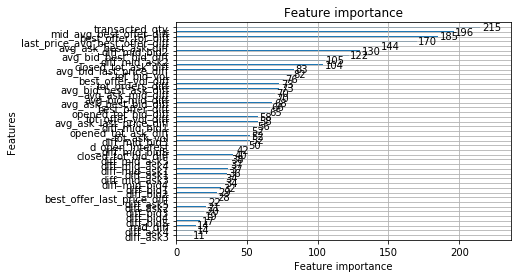

In [0]:
import lightgbm
lightgbm.plot_importance(clf5,max_num_features=10)

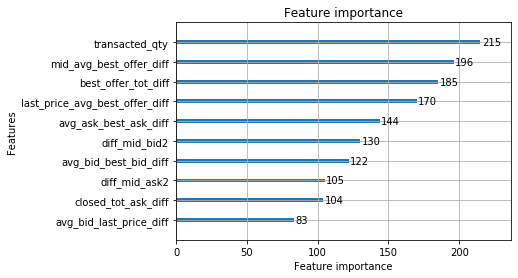

In [0]:
import lightgbm
lightgbm.plot_importance(clf5,max_num_features=10)

# Train Ensemble Model


In [0]:
from sklearn.svm import *
from sklearn.ensemble import BaggingClassifier

In [0]:
from sklearn.calibration import CalibratedClassifierCV


In [0]:
clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier()
clf3 = LogisticRegression()
clf4 = AdaBoostClassifier()
clf5 = LGBMClassifier()
clf6 = XGBClassifier()
linear_svc = LinearSVC()
clf8 = BaggingClassifier()
clf7 = CalibratedClassifierCV(linear_svc,
                                        method='sigmoid',  #sigmoid will use Platt's scaling. Refer to documentation for other methods.
                                        cv=3) 
eclf1 = VotingClassifier(estimators=[('gb', clf1), ('rf', clf2), ('logreg', clf3), ('ada', clf4),('lgbm', clf5),('xgb', clf6),('svc',clf7),('bbc',clf8)], voting='soft')
# eclf1 = eclf1.fit(X_train, y_train)
# print(eclf1.score(X_test, y_test))

In [0]:
y_probs = eclf1.predict_proba(X_test)
print(roc_auc_score(y_test, y_probs[:,1]))

0.676500927467801


# Create .csv of Test Set



In [0]:
test_df = pd.read_csv('test.csv', index_col=0)
test_df, __ = add_fields(test_df, with_y=False)

eclf1 = eclf1.fit(train_df, y)
probbs = eclf1.predict_proba(test_df)
test_df['Predicted'] = probbs[:, 1]

header = ["id", "Predicted"]
test_df['id']=test_df.index
test_df.to_csv('output.csv', columns = header,index=False)